In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
#Mount to folder in drive.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

!mkdir /tmp/T
!gsutil -m cp /gdrive/My\ Drive/HPA/archive.zip /tmp/
!unzip -q /tmp/archive.zip -d /tmp/T

Mounted at /gdrive
CommandException: No URLs matched: /gdrive/My Drive/HPA/archive.zip
CommandException: 1 file/object could not be transferred.
unzip:  cannot find or open /tmp/archive.zip, /tmp/archive.zip.zip or /tmp/archive.zip.ZIP.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zurkin11","key":"88235e18eb50a9ac6193eea424d6dfb4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d phalanx/hpa-512512

100% 8.91G/8.92G [02:59<00:00, 56.4MB/s]
100% 8.92G/8.92G [02:59<00:00, 53.5MB/s]


In [ ]:
!kaggle competitions download -c hpa-single-cell-image-classification -f train.csv

  0% 0.00/872k [00:00<?, ?B/s]
100% 872k/872k [00:00<00:00, 28.6MB/s]


In [ ]:
!mv train.csv /tmp/

In [ ]:
!mkdir /tmp/train
!unzip -q hpa-512512.zip -d /tmp/train

In [1]:
!pip install -U -q fastai

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2

from fastai import *
from fastai.vision import *
from fastai.vision.image import *

In [ ]:
import fastai
fastai.__version__

'1.0.61'

In [ ]:
# adapted from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb, https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier
def load_image(path, shape):
    R = np.array(Image.open(path+'_red.png'))
    G = np.array(Image.open(path+'_green.png'))
    B = np.array(Image.open(path+'_blue.png'))
    Y = np.array(Image.open(path+'_yellow.png'))

    image = np.stack((
        R/2 + Y/2, 
        G/2 + Y/2, 
        B),-1)
    
    image = cv2.resize(image, (shape[0], shape[1]))
    image = np.divide(image, 255)
    return image


def open_4_channel(fname):
    fname = str(fname)
    # strip extension before adding color
    if fname.endswith('.png'):
        fname = fname[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    return Image(pil2tensor(x, np.float32).float())

In [ ]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        # we initialize this conv to take in 4 channels instead of 3
        # we keeping corresponding weights and initializing new weights with zeros
        # this trick taken from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
bs = 64
path = Path('/tmp/')
df = pd.read_csv(path/'train.csv')
df.columns = ['Id', 'Target']
df.head()

Images: 21806


,Id,Target
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [ ]:
np.random.seed(42)
#src = (ImageList.from_csv(path, 'train.csv', folder='train', suffix='.png')
#       .random_split_by_pct(0.2)
#       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
src = ImageDataBunch.from_csv(path, csv_labels='train.csv', folder='train', suffix='_green.png', label_delim=' ') #.normalize(protein_stats)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
#src.train.x.create_func = open_4_channel
#src.train.x.open = open_4_channel
#src.valid.x.create_func = open_4_channel
#src.valid.x.open = open_4_channel

In [ ]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))
test_fnames = [path/'test'/test_id for test_id in test_ids]
test_fnames[:5]

In [ ]:
src.add_test(test_fnames, label='0');

LabelLists;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: .
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/william/data/human-protein-atlas-image-classification;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: .
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/william/data/human-protein-atlas-image-classification;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: .
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512

In [ ]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [ ]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [ ]:
data = (src.transform((trn_tfms, _), size=224)
        .databunch().normalize(protein_stats))

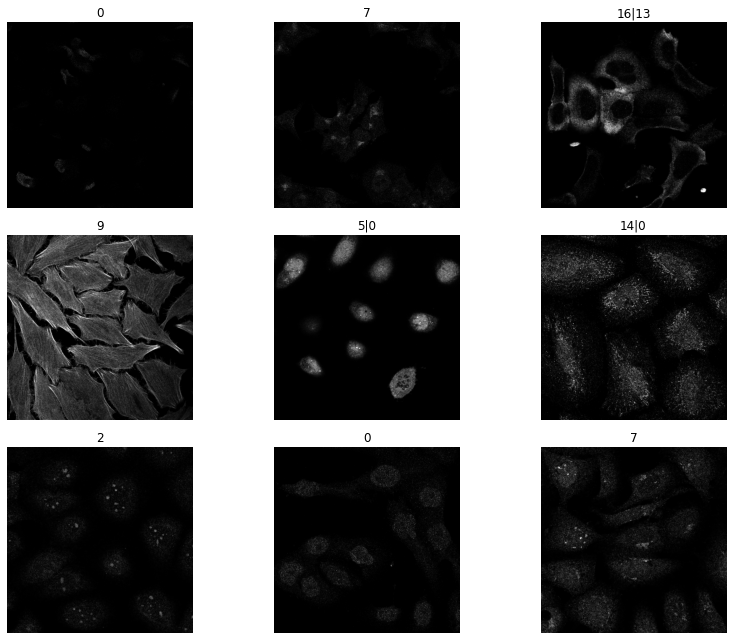

In [ ]:
#data.show_batch(rows=3, figsize=(12,9))
src.show_batch(rows=3, figsize=(12,9))

In [ ]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [ ]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [ ]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [ ]:
learn = cnn_learner(
    src,
    models.resnet18, #50
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


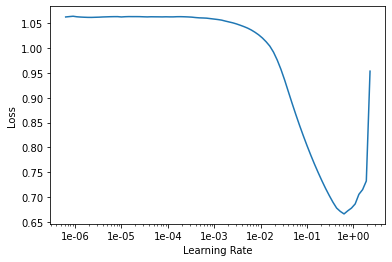

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta,time
0,0.023148,0.013104,0.105587,02:39
1,0.011484,0.010109,0.188336,02:24
2,0.010191,0.009383,0.249293,02:16
3,0.008993,0.008370,0.311198,02:16
4,0.007962,0.007982,0.355438,02:16


In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 10:40
epoch  train_loss  valid_loss  fbeta   
1      0.135880    0.143851    0.496961  (02:09)
2      0.137360    0.139784    0.518900  (02:07)
3      0.125225    0.126279    0.582821  (02:07)
4      0.115448    0.126466    0.626896  (02:07)
5      0.105616    0.105299    0.644369  (02:08)



In [ ]:
learn.save('stage-1-rn50-datablocks')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


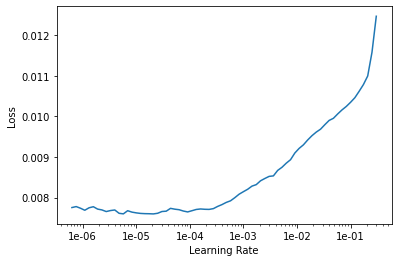

In [ ]:
learn.recorder.plot()

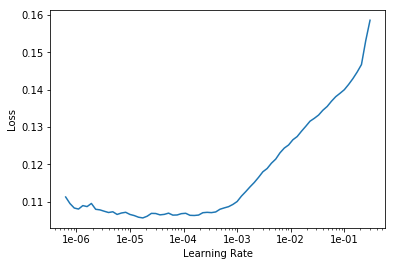

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

In [ ]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

Total time: 39:10
epoch  train_loss  valid_loss  fbeta   
1      0.109667    0.155611    0.626423  (02:36)
2      0.110943    0.114875    0.623779  (02:36)
3      0.109368    0.150954    0.612238  (02:36)
4      0.108172    0.141205    0.587201  (02:36)
5      0.108150    0.130050    0.637721  (02:36)
6      0.102617    0.108451    0.619096  (02:36)
7      0.102491    0.187115    0.635789  (02:36)
8      0.100008    0.098371    0.661671  (02:36)
9      0.096139    0.099643    0.683945  (02:36)
10     0.093640    0.094433    0.678350  (02:36)
11     0.089169    0.090767    0.688339  (02:36)
12     0.087881    0.088234    0.697956  (02:36)
13     0.085696    0.091604    0.696905  (02:36)
14     0.083266    0.087665    0.695674  (02:36)
15     0.083326    0.086742    0.699768  (02:36)



In [ ]:
learn.save('stage-2-rn50')

In [ ]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/william/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)

In [5]:
#################### UNET
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import torch
import torch.nn as nn

m = resnet34()
m = nn.Sequential(*list(m.children())[:-2])
tst = DynamicUnet(m, 5, (128,128), norm_type=None)
x = torch.randn(2, 3, 128, 128)
y = tst(x)
print(y.shape) #[2, 5, 128, 128]

torch.Size([2, 5, 128, 128])


In [11]:
cv_source = untar_data(URLs.CAMVID_TINY)

In [42]:
!cat /root/.fastai/data/camvid_tiny/codes.txt | wc -l

32


In [41]:
!ls -l /root/.fastai/data/camvid_tiny/images | wc -l

101


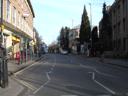

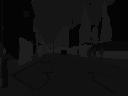

In [40]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/root/.fastai/data/camvid_tiny/images/0016E5_08550.png') #, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)
img2 = cv2.imread('/root/.fastai/data/camvid_tiny/labels/0016E5_08550_P.png') #, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img2)

In [43]:
img2.max()

31

In [9]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import *
from fastai.vision.data import *
from fastai.data.external import *
from fastai.data.transforms import *
from fastai.losses import *
import numpy as np


path = untar_data(URLs.CAMVID_TINY)
fnames = get_image_files(path/'images')
def label_func(x): return path/'labels'/f'{x.stem}_P{x.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str)
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes)

#tst = unet_learner(models.resnet18, 10, (24,24), True, n_in=1)
tst = unet_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(axis=1), y_range=(0,1))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
